In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/telecom-churn/telecom_churn.csv


# Table of Content:

[1. Introduction](#1)

[2. Data Overview](#2)

[3. EDA](#3)

[4. Feature Engineering ](#4)

[5. Basic Model Fitting](#5)
* [5.1. Basic Model Evaluation](#6)
* [5.2. Rebalance Sample Size](#7)
* [5.3. Model With Added Features](#8)

[6. Model Tunning: Precision vs. Recall curve](#9)

[7. Final Test](#10)

[Additional: Business Insights](#11)

<a id="1"></a>
# 1. Introduction

### Business Questions:
1. Which customers are more likely to churn?
2. Why? Which factors make them them more likely to churn?
3. How confident are we with our model?

### Variables: 
* Churn: 1 if customer cancelled service, 0 if not
* AccountWeeks: number of weeks customer has had active account
* ContractRenewal: 1 if customer recently renewed contract, 0 if not
* DataPlan: 1 if customer has data plan, 0 if not
* DataUsage: gigabytes of monthly data usage
* CustServCalls: number of calls into customer service
* DayMins: average daytime minutes per month
* DayCalls: average number of daytime calls
* MonthlyCharge: average monthly bill
* OverageFee: largest overage fee in last 12 months
* RoamMins: average number of roaming minutes

### Goal: to correctly identify customers who will churn so that we can keep them.

<a id="2"></a>
# 2. Data Overview

In [2]:
#Load the data
df = pd.read_csv("/kaggle/input/telecom-churn/telecom_churn.csv")
df.sample(5)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
962,0,107,1,0,0.47,3,212.1,95,53.7,7.51,7.7
1708,0,92,1,1,3.02,4,167.4,83,81.2,12.93,11.2
2381,0,64,1,1,2.05,1,200.4,80,66.5,6.56,7.6
2321,0,153,1,0,0.29,1,154.6,56,51.9,13.15,15.5
722,0,113,1,0,0.00,1,215.6,96,54.0,9.67,13.5


In [3]:
#check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
Churn              3333 non-null int64
AccountWeeks       3333 non-null int64
ContractRenewal    3333 non-null int64
DataPlan           3333 non-null int64
DataUsage          3333 non-null float64
CustServCalls      3333 non-null int64
DayMins            3333 non-null float64
DayCalls           3333 non-null int64
MonthlyCharge      3333 non-null float64
OverageFee         3333 non-null float64
RoamMins           3333 non-null float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


- No missing Data - Great!
- No Categorical variables - Great!

Ambigious varaible: Customer Service Call 
1. I wonder if the customer service call is the average numbers of call/month, or the most recent month's call or the total amount of calls that customer have made. 
2. We don't have any ideas on when the calls were made. 5 recent customers service calls can be an indicator to predict the churn, while 5 customer service calls that were made a year ago will not be an indicator


<a id="3"></a>
# 3. EDA

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

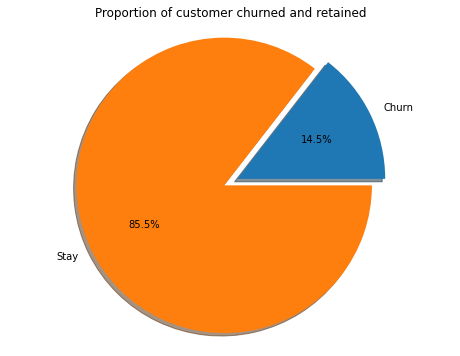

In [5]:
#default churn rate
labels = 'Churn', "Stay"
sizes = [df.Churn[df['Churn'] == 1].count(), df.Churn[df['Churn'] == 0].count()]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customer churned and retained")

plt.show()

In [6]:
#Let's look at the relationship between variables

#preperation
df_hue = df.copy()
df_hue["Churn"] = np.where(df_hue["Churn"] == 0, "S", "C")
df_new = df_hue[["Churn","AccountWeeks", "DataUsage", "CustServCalls", "DayMins", "DayCalls", "MonthlyCharge", "OverageFee", "RoamMins"]]

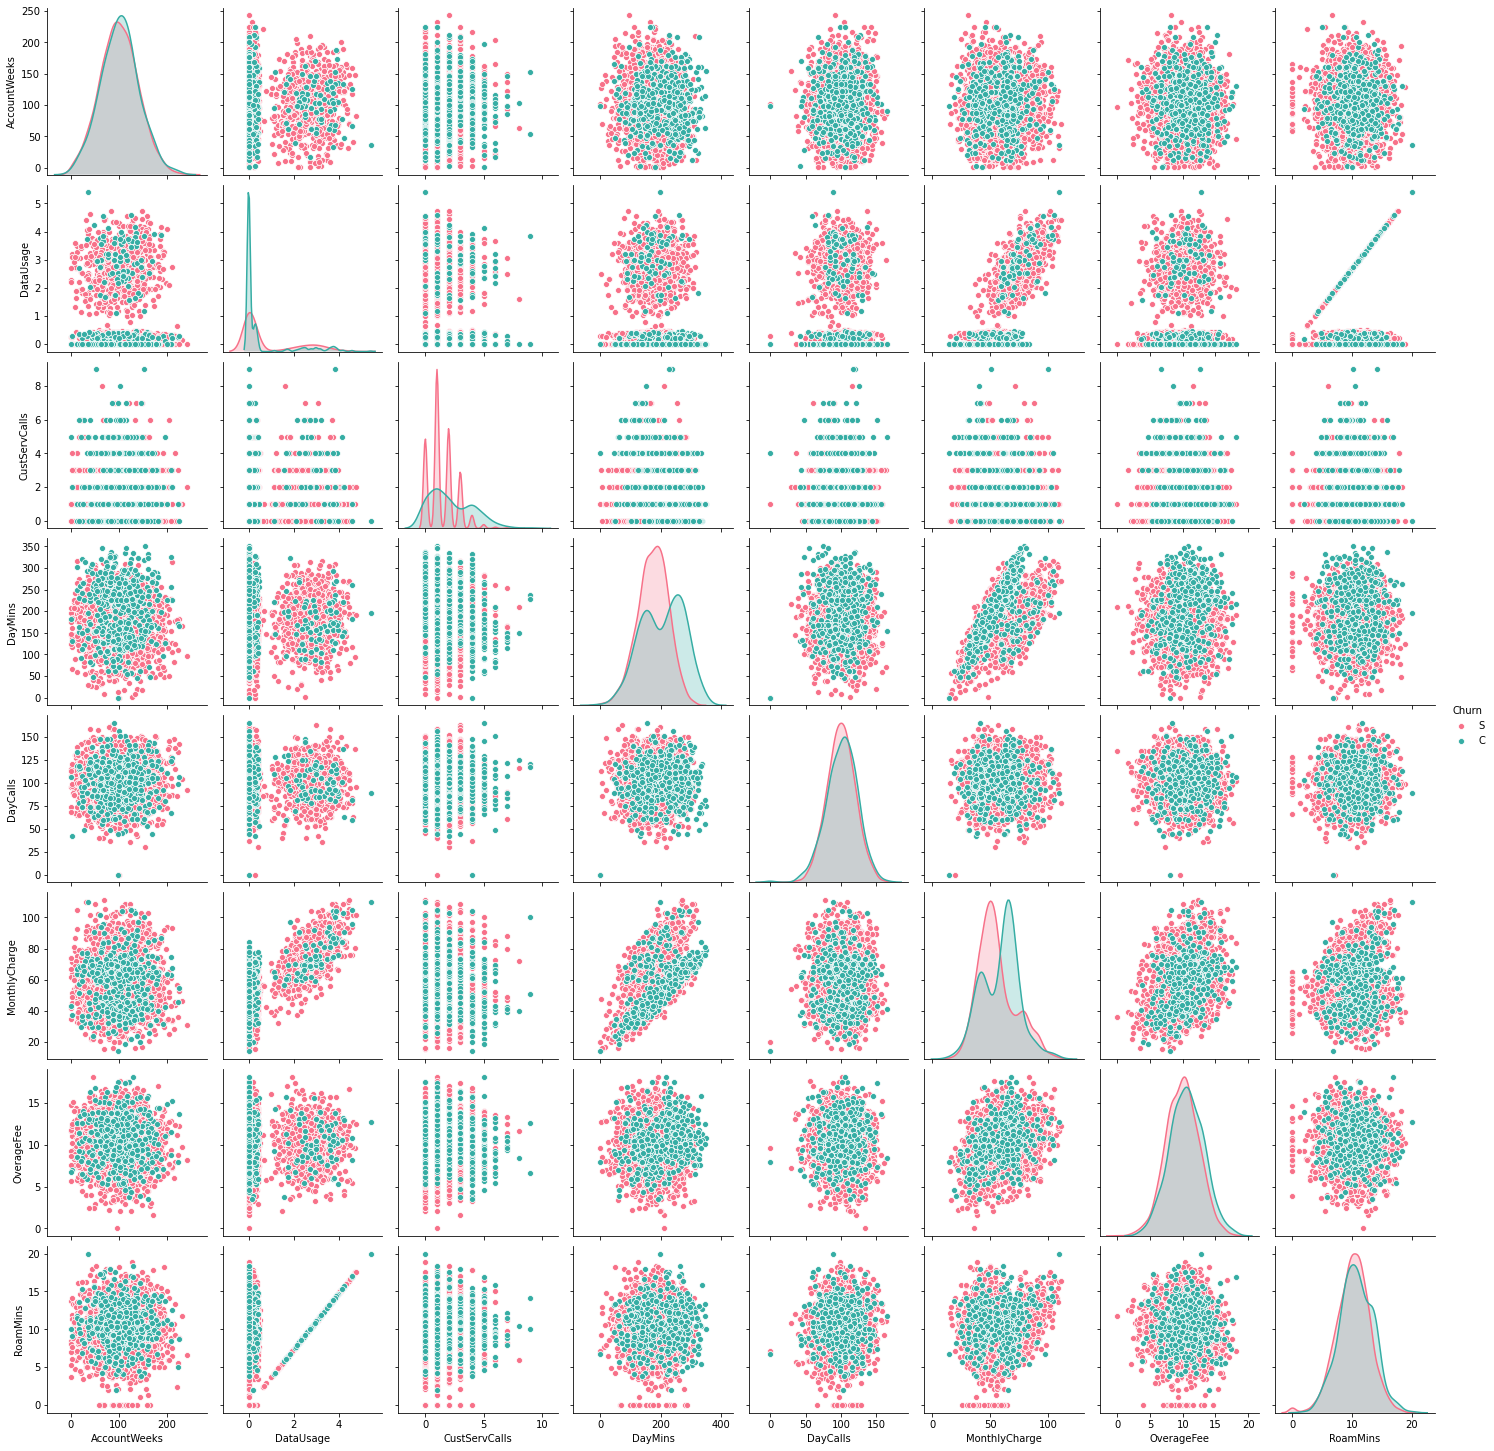

In [7]:
#A master view at all the numerical variables
sns.pairplot(df_new, hue="Churn", palette="husl")

Noticeable things from density graph:
* **Daysmins** and **MonthlyCharge** would be helpful for us to seperate the groups. Maybe I can look into what might relate to them so that I can amplify the difference during feature engineering. 
* Group *"Churned"* has a disporpotionally high **DataUsage** of 0. It is hard to see why it is the case for now. However in generally DataUsage is highly skewed with lots of 0. 
* For **CustomerServiceCalls**, group *"Stay"* is as likely to make a call as Group *"Churn"* and the mode is around 2 calls. However, when it is more than 3 or 4 calls, it's mostly only Group *"Churn"*. 

Noticeable things between two different variables:
* **DataUsage** has a linear relationship with **RoamMins** for the ones that are not 0. This needs further investigation to see if we can just use one of the variables. 
* **MonthlyCharge** has a positive relationship with **DataUsage**, **DayMins** and **OverageFee**

In [8]:
def boxplots (df, variables, n_rows=None, n_cols=None, hue="Churn"):
    '''Draw boxplots to examine the churn behavior of each continuous variable. 

    Args:
    variables: list. A list of variables that you would like to examine
    n_rows, n_cols: int. 
    hue: Because the context here is a churn analysis, so I set the default to "Churn". 
    
    Returns:
    boxplots of all the variables that were passed in the format of that you specify. 
    '''
    fig=plt.figure(figsize=(20,16))
    sns.set(palette='pastel')
    for i, var in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        sns.boxplot(y=var, x=hue, hue=hue, data=df, ax=ax).set_title(var)
    plt.show()

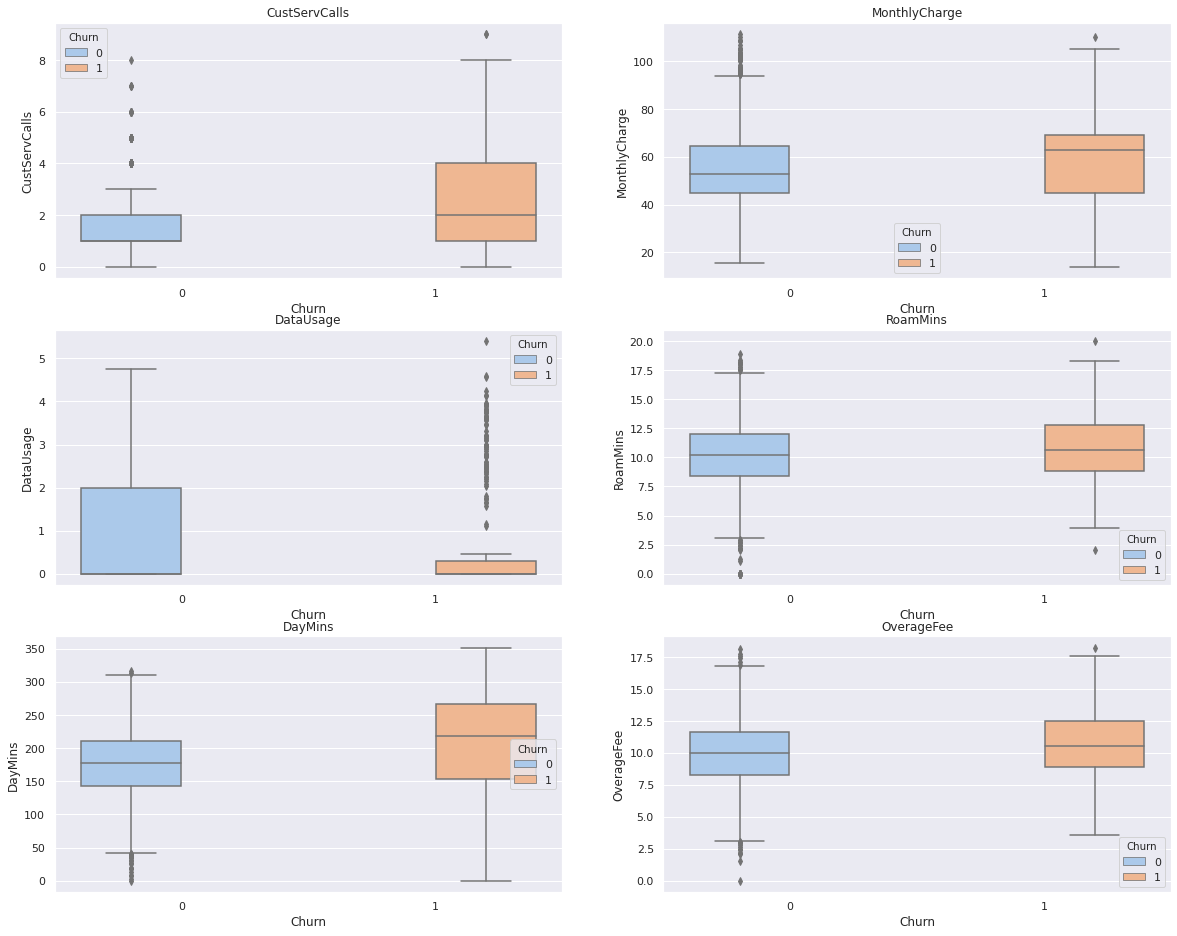

In [9]:
continue_variables = df[["CustServCalls", "MonthlyCharge", "DataUsage", "RoamMins", "DayMins", "OverageFee"]]

boxplots(df, continue_variables, 3, 2)

Noticiable thing from the boxplot: 

* Monthly charge is about 15 dollar higher for Group *"Churn"*
* For DayMins, the standard deviation of the Group *"Churn"* is almost twice of the Group *"Stay"*.
* 75% of customers from Group *"Stay"* have 2 calls to CustServCall and very few customers have more than 3 calls. However, for the Group *"Churn"* the means is 2 calls, 75% are within 4 calls while we still have a considerable amount of people go up to 8 calls.
* For DataUsage, like previously mentioned, while more than 75% of the Group *"Churn"* are 0, the rest of the group is spread across the spectrum.

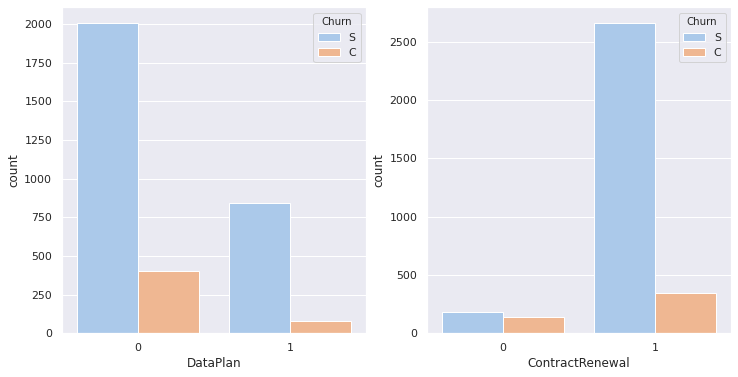

In [10]:
#Let's quickly look at the histogram of categorical varaibles
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='DataPlan', hue = 'Churn',data = df_hue, ax=axarr[0], palette="pastel")
sns.countplot(x='ContractRenewal', hue = 'Churn',data = df_hue, ax=axarr[1], palette="pastel")

Noticeable things from histogram:
* The two variables are highly skewed. Majority of the samples in Group *"no data plan"* but *with contract renewal* recently. 
* In Group *"no data plan"*, the propotion of Group *"Churn"* is higher than in group *"with data plan"*. 
* For ContractRenewal, Group *"no contract renewal"*, propotion of Group *"Churn"* is significantly higher compare to the propotion in Group "with contract renewal". 
* I wonder how the samples were collected. The different behaviors in the two groups can be actual difference but can also be due to incomplete data collection. 

Connecting to the previous analysis: 
* I think why we have lots of 0 in dataUsage was because we have lots of customers in Group *"no data plan"*. 

In [11]:
#Let's do a quick check to see if all the 0 in DataUsage is due to the O in DataPlan
#in percentage
nousage_perce = (len(df[df["DataUsage"]==0])/len(df))*100
noplan_perce = (len(df[df["DataPlan"]==0])/len(df)) *100
print("The percentage for people with 0 data usage is " + str(round(nousage_perce, 2)) + " percent")
print("The percentage for people with no data plan is " + str(round(noplan_perce, 2)) + " percent")

#in absolute number 
nousage = len(df[df["DataUsage"]==0])
noplan = len(df[df["DataPlan"]==0])
print(str(nousage) + " numbers of people have 0 data usage.")
print(str(noplan) + " numbers of people have 0 data plan.")
print("\nInsight: 598 people who did not purchase a data plan were also using data. Let's check the roaming data.")

#for the people who didn't have a data plan but still have data usage, to they belong to roaming?
#Roaming info
roam = len(df[df["RoamMins"]!=0])
print("\n" + str(roam) + " numbers of people used roaming.")
print("\nInsight: Seems like almost everyone uses Roaming and it does not relates to wheather you use data.")

The percentage for people with 0 data usage is 54.4 percent
The percentage for people with no data plan is 72.34 percent
1813 numbers of people have 0 data usage.
2411 numbers of people have 0 data plan.

Insight: 598 people who did not purchase a data plan were also using data. Let's check the roaming data.

3315 numbers of people used roaming.

Insight: Seems like almost everyone uses Roaming and it does not relates to wheather you use data.


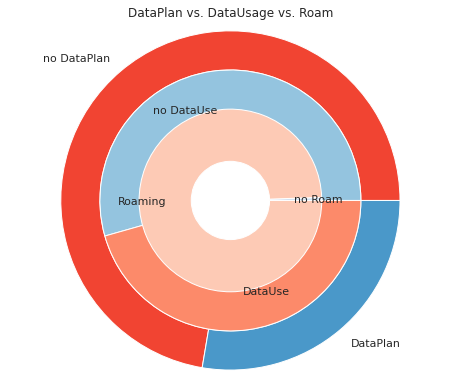

In [12]:
#using a pie chart to visualize the relationship between the three variables

group_names=['no DataPlan', 'DataPlan']
group_size=[2411, (3333-2411)]

subgroup1_names=['no DataUse','DataUse']
subgroup1_size=[1813, (3333-1813)]

subgroup2_names=['no Roam', 'Roaming']
subgroup2_size=[(3333-3315), 3315]
 
# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (Outside)
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[b(0.6), a(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup1_size, radius=1.3-0.3, labels=subgroup1_names, labeldistance=0.7, colors=[a(0.4), b(0.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

# Third Ring (Most Inner)
mypie3, _ = ax.pie(subgroup2_size, radius=1.3-0.3-0.3, labels=subgroup2_names, labeldistance=0.7, colors=[a(0.2), b(0.2)])
plt.setp( mypie3, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
ax.set(title='DataPlan vs. DataUsage vs. Roam\n')
plt.show()


In [13]:
def piecharts (df, cat_variables, n_rows=None, n_cols=None, hue="Churn"):
    '''Draw pie charts to examine the churn behavior of each categorical variable. 

    Args:
    attributes: list. A list of attributes that you would like to examine
    n_rows, n_cols: int. 
    hue: Because the context here is a churn analysis, so I set the default to "Churn". 
    
    Returns:
    boxplots of all the attributes that were passed in the format of that you specify. 
    '''
    fig=plt.figure(figsize=(18,10))
    explode = (0, 0.1)
    labels=['Churn', 'Not Churn']
    for i, var in enumerate(cat_variables):
        df_0 = [len(df[(df[var]==0) & (df[hue]==1)]), len(df[(df[var]==0) & (df[hue]==0)])] #when the cat_var == 0
        
        ax0=fig.add_subplot(n_rows, n_cols, i+1)
        ax0.pie(df_0, explode=explode, labels=labels, autopct='%1.1f%%')
        ax0.set_title("Do not have {}".format(var))
        
    for i, var in enumerate(cat_variables):
        df_1 = [len(df[(df[var]!=0) & (df[hue]==1)]), len(df[(df[var]!=0) & (df[hue]==0)])] #when the cat_var == 1
        
        ax1=fig.add_subplot(n_rows, n_cols, i+1+n_rows)
        ax1.pie(df_1, explode=explode, labels=labels, autopct='%1.1f%%')
        ax1.set_title("Have {}".format(var))
    plt.show()

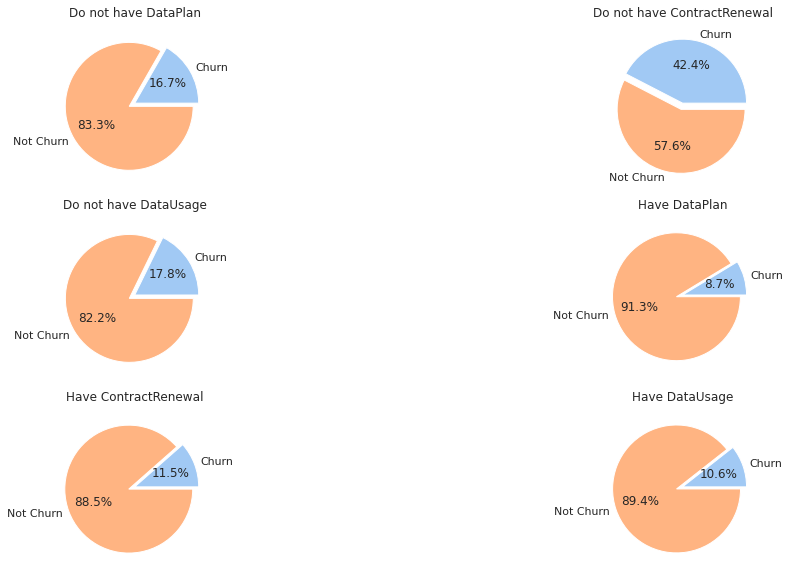

In [14]:
cat_variables = df[["DataPlan", "ContractRenewal", "DataUsage"]] 

piecharts(df, cat_variables, 3, 2)

- DataPlan: Customers who did not purchase a data plan has a significant larger change to churn. I wonder if this is because they still use data though without a data plan, which result in a higher fee. 

- ContractRenewal: Customers who did not renew our plan has a significantly larger churn. Thus, this can be a good variable to use in our prediction. However, we need to keep in mind that we have very uneven sample size. So the difference might only due to incomeplete data collection. 

- DataUsage: Customers who did not use data at all has a 7% larger churn rate. This could help us in the perdiction. THus, I will add the categorical feature. 
    - I wonder if this relates to they would call more often. And Calling time has a positive relationship with Monthly fee. Thus, customers churn due to high fees. However, this is only an assumption.

### To investigate the reseaon behind churn rate difference between group "Have Dataplan" and "No Dataplan"

In [15]:
df_model = df.copy()

In [16]:
#To investigate why churn rate is so different between group "Have Dataplan" and "No Dataplan". I create a new variable, peopel who didn't have a data plan but still used data
df_model["data_w_noplan"]=np.where((df_model["DataPlan"]==0) & (df_model["DataUsage"]!=0), 1, 0)

Text(0.5, 1.0, 'Customers who used data but did not purchase a plan')

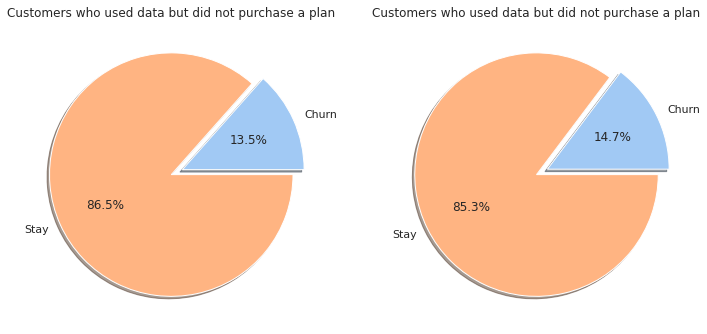

In [17]:
#let's see if it is useful for our prediction
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
data_w_noplan = [len(df_model[(df_model["data_w_noplan"]==1) & (df_model["Churn"]==1)]), len(df_model[(df_model["data_w_noplan"]==1) & (df_model["Churn"]==0)])]
ax[0].pie(data_w_noplan, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax[0].set_title("Customers who used data but did not purchase a plan")

data_w_plan = [len(df_model[(df_model["data_w_noplan"]==0) & (df_model["Churn"]==1)]), len(df_model[(df_model["data_w_noplan"]==0) & (df_model["Churn"]==0)])]
ax[1].pie(data_w_plan, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax[1].set_title("Customers who used data but did not purchase a plan")

In [18]:
#it was useless. Let's drop that. 
df_model.drop(['data_w_noplan'], axis = 1)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


In [19]:
#Let's see if it relates to still using a roaming service while didn't purchase a data plan. 
df_model["roam_w_noplan"]=np.where((df_model["DataPlan"]==0) & (df_model["RoamMins"]!=0), 1, 0)

Text(0.5, 1.0, 'Customers who roam but purchased a data plan')

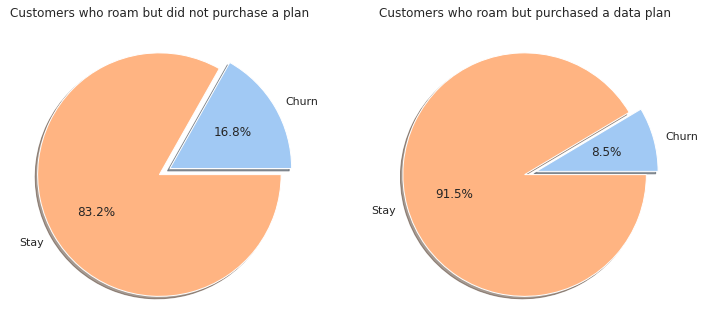

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
roam_w_noplan = [len(df_model[(df_model["roam_w_noplan"]==1) & (df_model["Churn"]==1)]), len(df_model[(df_model["roam_w_noplan"]==1) & (df_model["Churn"]==0)])]
ax[0].pie(roam_w_noplan, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax[0].set_title("Customers who roam but did not purchase a plan")

roam_w_plan = [len(df_model[(df_model["roam_w_noplan"]==0) & (df_model["Churn"]==1)]), len(df_model[(df_model["roam_w_noplan"]==0) & (df_model["Churn"]==0)])]
ax[1].pie(roam_w_plan, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax[1].set_title("Customers who roam but purchased a data plan")

#people who doesn't have a data plan and churn were more likely due to the fact that they still use the roaming service. 

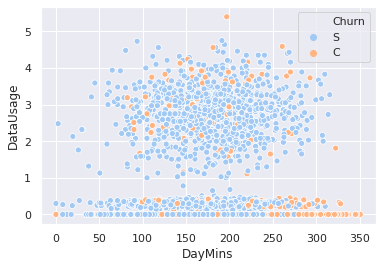

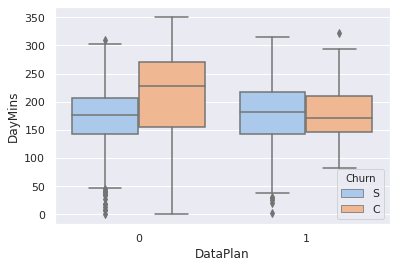

In [21]:
#let's see if people with 0 data usage uses calls more often
sns.scatterplot(x='DayMins', y="DataUsage", hue = 'Churn', data = df_hue, palette="pastel")
#Seems like it is not that people with low data usage will call more often but that people who doesn't have data usage and still have make lots of calls are very likely to be churn. However, 0 data usage are mostly due to wheather they have a data plan or not.

#relationship between dataplan and Daymins
fig = plt.subplots()
sns.boxplot(x='DataPlan', y="DayMins", hue = 'Churn', data = df_hue, palette="pastel")

#### Conclusion: On Average, people who didn't purchase a data plan and uses lots of minutes are very likely to be churn. 

## 4. Feature Engineering

#### Because our dataset is very clean to start with, I will do explore some feature engineering in this section. 

In [22]:
# create new cat_varibale for data usage
df["datausage_dummy"] = np.where(df["DataUsage"]!=0, 1, 0)

In [23]:
#For people who didn't purchase a data plan. I squared the data so that I amplify the affect of havnig lots of call minutes.  
df_model["DayMins_noplan"]=np.where((df_model["DataPlan"]==0) & (df_model["DayMins"]!=0), df_model.DayMins**2, df_model.DayMins**2)

Text(0.5, 1.0, '\nOriginal Day Mins Distribution \n In Customer Attrition')

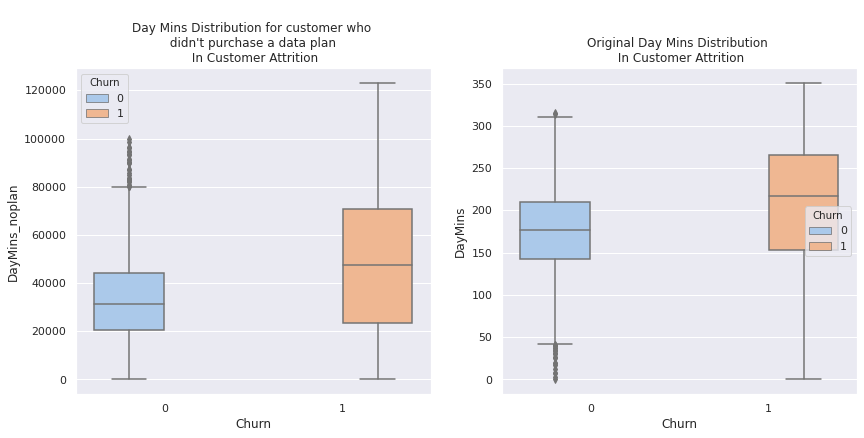

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.boxplot(y="DayMins_noplan", x="Churn", hue = "Churn", ax=ax[0], data=df_model).set_title("\nDay Mins Distribution for customer who \n didn't purchase a data plan \n In Customer Attrition")
sns.boxplot(y="DayMins", x="Churn", hue = "Churn", ax=ax[1], data=df).set_title("\nOriginal Day Mins Distribution \n In Customer Attrition")
#Let's see if it helps with the model

<a id="5"></a>
# 5. Basic Model fitting with original data

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [26]:
#dat preperation
label = df["Churn"]
df_train1 = df.iloc[:, 1:].copy()
feature_names = list(df_train1.columns.values)

#I seperate the data into train, valiation and test. We will reserve the test set till the end to test the performance of the best model.

#set, testset
X_trainval, X_test, y_trainval, y_test = train_test_split(df_train1, label, test_size = 0.2, random_state=1)
#train, validation set split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state=1)

### Baseline Model

In [27]:
def modelling(classifiers, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    
    for i, clf in enumerate(classifiers):
        model = clf.__class__.__name__
        clf.fit(X_train, y_train)
        score = clf.score(X_val, y_val)
        cross_val = cross_val_score(clf, X_val, y_val)

        print("\n{}\nModel accuracy: {}.\nCross-valdation score: {}.".format(model, score, cross_val.mean()))

In [28]:
clf_list = [DummyClassifier(random_state=1), DecisionTreeClassifier(random_state=1, max_depth = 6), RandomForestClassifier(random_state=1, max_depth=8), GradientBoostingClassifier(random_state=1), XGBClassifier(random_state=1)]

modelling(clf_list)

/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)



DummyClassifier
Model accuracy: 0.7340823970037453.
Cross-valdation score: 0.7116205254805148.

DecisionTreeClassifier
Model accuracy: 0.9250936329588015.
Cross-valdation score: 0.883900546640804.

RandomForestClassifier
Model accuracy: 0.9325842696629213.
Cross-valdation score: 0.9194850996296949.

GradientBoostingClassifier
Model accuracy: 0.9325842696629213.
Cross-valdation score: 0.9120084641156762.

XGBClassifier
Model accuracy: 0.9194756554307116.
Cross-valdation score: 0.9138599894198555.


<a id="6"></a>
# 6. Basic model Evaluation

In [29]:
def confusion_matrices(clfs, X_train=X_train, y_train=y_train, X_val=X_val, y_test=y_val):
    
    for i, clf in enumerate(clfs):
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        pred_y = clf.predict(X_val)
        matrix_norm = confusion_matrix(y_val, pred_y, normalize='all')
        matrix= confusion_matrix(y_val, pred_y)
        print("\n{} Confusion Matrix:\n{}\n{}".format(name, matrix, matrix_norm))

In [30]:
confusion_matrices(clf_list)


DummyClassifier Confusion Matrix:
[[379  73]
 [ 69  13]]
[[0.70973783 0.13670412]
 [0.12921348 0.02434457]]

DecisionTreeClassifier Confusion Matrix:
[[445   7]
 [ 33  49]]
[[0.83333333 0.01310861]
 [0.06179775 0.0917603 ]]


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)



RandomForestClassifier Confusion Matrix:
[[446   6]
 [ 30  52]]
[[0.83520599 0.01123596]
 [0.05617978 0.09737828]]

GradientBoostingClassifier Confusion Matrix:
[[444   8]
 [ 28  54]]
[[0.83146067 0.01498127]
 [0.05243446 0.1011236 ]]

XGBClassifier Confusion Matrix:
[[438  14]
 [ 29  53]]
[[0.82022472 0.02621723]
 [0.05430712 0.09925094]]


From the classification report aboved, the difference between the model's ability to predict "Stay" vs. to predict "Churn is even more obvious. Here are some reminders what "precision" and "recall" are:
* Precision: True Positive / (True Positive + False Positive). Let's translate to Englis and let's use the example of "Churn", which is 0.88. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict churn but the client stay) is 88% 
* Recall: True Positive / (True Positive + False Negative). Let's translate to Englis and let's use the example of "Churn", which is 0.63. It means: The times the model rightly predicted customers will churn / (rightly predict churn + predict stay but the client churn) is 63% 

<a id="7"></a>
# 7. downsample to rebalance dataset

#### I did a seperate project to justify why I use downsampling instead of other methods to rebalance this dataset. See the resources below: 
- Analysis: https://www.kaggle.com/taliac/different-resampling-methods-for-trees
- Blog post: https://towardsdatascience.com/from-imbalanced-dataset-to-boosting-algorithms-1-2-798cd6384ecc?source=friends_link&sk=4b74e0b8992d3011e921cfa541c4afab

In [31]:
from sklearn.utils import resample

In [32]:
# Separate majority and minority classes
df_maj = df[df.Churn==0]
df_min = df[df.Churn==1]

print("The minority sample size is: {}".format(len(df_min))) #483

# Downsample majority class
df_maj_ds = resample(df_maj, replace=False,    # sample without replacement
                             n_samples=483,     # to match minority class
                             random_state=1) # reproducible results
# Combine minority class with downsampled majority class
df_ds = pd.concat([df_maj_ds, df_min])
 
# Display new class counts
df_ds.Churn.value_counts()


The minority sample size is: 483


1    483
0    483
Name: Churn, dtype: int64

In [33]:
#dat preperation
label2 = df_ds["Churn"]
df_ds_train = df_ds.iloc[:, 1:].copy()
feature_names2 = list(df_ds_train.columns.values)
#set, testset split
Xds_train, Xds_val, yds_train, yds_val = train_test_split(df_ds_train, label2, test_size = 0.2, random_state=1)

In [34]:
modelling(clf_list, Xds_train, yds_train, Xds_val, yds_val)


DummyClassifier
Model accuracy: 0.4948453608247423.
Cross-valdation score: 0.5056680161943319.

DecisionTreeClassifier
Model accuracy: 0.8608247422680413.
Cross-valdation score: 0.8251012145748987.


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)



RandomForestClassifier
Model accuracy: 0.8917525773195877.
Cross-valdation score: 0.87638326585695.

GradientBoostingClassifier
Model accuracy: 0.8814432989690721.
Cross-valdation score: 0.860863697705803.

XGBClassifier
Model accuracy: 0.845360824742268.
Cross-valdation score: 0.8192982456140351.


In [35]:
confusion_matrices(clf_list, Xds_train, yds_train)


DummyClassifier Confusion Matrix:
[[211 241]
 [ 42  40]]
[[0.39513109 0.45131086]
 [0.07865169 0.07490637]]

DecisionTreeClassifier Confusion Matrix:
[[410  42]
 [ 11  71]]
[[0.76779026 0.07865169]
 [0.02059925 0.1329588 ]]


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)



RandomForestClassifier Confusion Matrix:
[[422  30]
 [  6  76]]
[[0.79026217 0.05617978]
 [0.01123596 0.1423221 ]]

GradientBoostingClassifier Confusion Matrix:
[[413  39]
 [  6  76]]
[[0.77340824 0.07303371]
 [0.01123596 0.1423221 ]]

XGBClassifier Confusion Matrix:
[[395  57]
 [  2  80]]
[[0.73970037 0.10674157]
 [0.00374532 0.14981273]]


The overall accuracy decreased. However, our recall rate greatly increased! This is what we want because our goal is to identify people who will churn so that we can do something about it. Now, with a great recall rate, let's see if we can improve the overall accuracy rate further. 
- We will first look at how our model will perform with newly added feature. 
- Then we will pick the best model to look at precision vs. recall curve to tune it. 

<a id="8"></a>
# 8. model with added features

In [36]:
# balance that dataset first

# Separate majority and minority classes
df_maj2 = df_model[df_model.Churn==0]
df_min2 = df_model[df_model.Churn==1]

print("The minority sample size is: {}".format(len(df_min2))) #483

# Downsample majority class
df_maj2_ds = resample(df_maj2, replace=False,    # sample without replacement
                             n_samples=483,     # to match minority class
                             random_state=1) # reproducible results
# Combine minority class with downsampled majority class
df_ds2 = pd.concat([df_maj2_ds, df_min2])
 
# Display new class counts
df_ds2.Churn.value_counts()

The minority sample size is: 483


1    483
0    483
Name: Churn, dtype: int64

In [37]:
#data preperation
label3 = df_ds2["Churn"]
df_ds_train2 = df_ds2.iloc[:, 1:].copy()
feature_names3 = list(df_ds_train2.columns.values)
#set, testset split
Xds_train2, Xds_val2, yds_train2, yds_val2 = train_test_split(df_ds_train2, label3, test_size = 0.2, random_state=1)

In [38]:
modelling(clf_list, Xds_train2, yds_train2, Xds_val2, yds_val2)


DummyClassifier
Model accuracy: 0.4948453608247423.
Cross-valdation score: 0.5056680161943319.

DecisionTreeClassifier
Model accuracy: 0.8505154639175257.
Cross-valdation score: 0.8251012145748987.


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)



RandomForestClassifier
Model accuracy: 0.8865979381443299.
Cross-valdation score: 0.8403508771929824.

GradientBoostingClassifier
Model accuracy: 0.8814432989690721.
Cross-valdation score: 0.8659919028340081.

XGBClassifier
Model accuracy: 0.8402061855670103.
Cross-valdation score: 0.8192982456140351.


So, actually the newly created features didn't help at all. Let's go with the original model. 

In [39]:
#tree after feature engineering
tree_ds2 = DecisionTreeClassifier(random_state=1, max_depth = 6).fit(Xds_train2, yds_train2)
print("Tree validation score: {:.2f}".format(tree_ds2.score(Xds_val2, yds_val2)))
tree_ds_crossval2 = cross_val_score(tree_ds2, Xds_val2, yds_val2)
print("Tree cross-validation score: {:.2f}".format(tree_ds_crossval2.mean()))
print("\nFeature Importantce ranking "+ str(sorted(zip(map(lambda x: round(x, 4), tree_ds2.feature_importances_), feature_names3), 
             reverse=True)))

Tree validation score: 0.85
Tree cross-validation score: 0.83

Feature Importantce ranking [(0.2623, 'DayMins'), (0.2237, 'ContractRenewal'), (0.2109, 'CustServCalls'), (0.1604, 'OverageFee'), (0.056, 'MonthlyCharge'), (0.0358, 'RoamMins'), (0.0194, 'DayCalls'), (0.0188, 'DayMins_noplan'), (0.0112, 'AccountWeeks'), (0.0014, 'DataUsage'), (0.0, 'roam_w_noplan'), (0.0, 'data_w_noplan'), (0.0, 'DataPlan')]


<a id="9"></a>
# 9. precision vs. recall curve

#### The ability to predict Group "Churn" accurately improved a lot after we rebalance the dataset. However, let's see the precision-recall to see if we are at the optimal tradeoff point. Because XGboost had the lowest False Positive error and a relatively good accuracy, I will use it to tune. 

In [40]:
xg = XGBClassifier(random_state=1).fit(Xds_train, yds_train)
pred_xg = xg.predict(X_val)

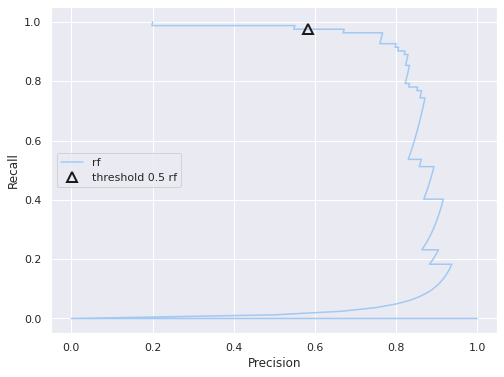

In [41]:
fig= plt.subplots(figsize=(8, 6))
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_val, xg.predict_proba(X_val)[:, 1])
plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='threshold 0.5 rf', fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

Looks like we can maintain the same recall rate and improve the overall accuracy with an adjustment of the rate of threshold.

In [42]:
threshold = 0.68 #after different trails, this is the best

predicted_proba = xg.predict_proba(X_val)
tune_pred = (predicted_proba [:,1] >= threshold).astype('int')

#compare the accuracy scores
accuracy_adj = accuracy_score(y_val, tune_pred)
print("accurcy rate with 0.56 threshold {}".format(str(round(accuracy_adj,4,)*100))+"%")

accuracy = accuracy_score(y_val, pred_xg)
print("accurcy rate with 0.5 threshold {}".format(str(round(accuracy,4,)*100))+"%")

#confusion matrix compare
confusion_tune=confusion_matrix(y_val, tune_pred)
print("confusion matrix with new threshold:\n{}".format(confusion_tune))

confusion_ds=confusion_matrix(y_val, pred_xg)
print("\nconfusion matrix original:\n{}".format(confusion_ds))

#classification_report
print("\nxgboost  classification report with adjuested threshold\n")
print(classification_report(y_val, tune_pred, target_names = ["Stay", "Churn"]))

accurcy rate with 0.56 threshold 92.32000000000001%
accurcy rate with 0.5 threshold 88.94999999999999%
confusion matrix with new threshold:
[[413  39]
 [  2  80]]

confusion matrix original:
[[395  57]
 [  2  80]]

xgboost  classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       1.00      0.91      0.95       452
       Churn       0.67      0.98      0.80        82

    accuracy                           0.92       534
   macro avg       0.83      0.94      0.87       534
weighted avg       0.95      0.92      0.93       534



<a id="10"></a>
# 10. final test

In [43]:
print("XG boost final test score: {:.2f}".format(xg.score(X_test, y_test)))
test_crossval = cross_val_score(xg, df_train1, label)
print("XG boost final cross-validation test score: {:.2f}".format(test_crossval.mean()))

test_xg = xg.predict(X_test)
confusion_test=confusion_matrix(y_test, test_xg)
print("\nconfusion matrix:\n{}".format(confusion_test))

test_proba = xg.predict_proba(X_test)

test = (test_proba [:,1] >= threshold).astype('int')

accuracy_test = accuracy_score(y_test, test)

print("\naccurcy rate with test data with {} threshold is {}".format(threshold, str(round(accuracy_test,4,)*100))+"%")

      
print("\nxg boosting classification report with adjuested threshold\n")
print(classification_report(y_test, test, target_names = ["Stay", "Churn"]))

XG boost final test score: 0.89
XG boost final cross-validation test score: 0.93

confusion matrix:
[[498  71]
 [  2  96]]

accurcy rate with test data with 0.68 threshold is 90.85%

xg boosting classification report with adjuested threshold

              precision    recall  f1-score   support

        Stay       1.00      0.90      0.94       569
       Churn       0.62      0.98      0.76        98

    accuracy                           0.91       667
   macro avg       0.81      0.94      0.85       667
weighted avg       0.94      0.91      0.92       667



<a id="11"></a>
# Additional: Business Insights

### How useful is our model?

In [44]:
#if we do not use a model
dummy = DummyClassifier().fit(X_train, y_train)
test_dummy = dummy.predict(X_test)

#comparsion
tn_dummy, fp_dummy, fn_dummy, tp_dummy = confusion_matrix(y_test,test_dummy).ravel()

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test).ravel()

#assume we have 4000 customers per month 
lost_dummy = (fn_dummy/(tn_dummy+fp_dummy+tp_dummy))*4000
lost_model = (fn_test/(tn_test+fp_test+tp_test))*4000
print("Assume we have 4000 customers per month, with random guessing, we will miss "+str(math.ceil(lost_dummy))+" customers who will change their phone plans.")
print("Assume we have 4000 customers per month, with the final model, we will miss "+str(math.ceil(lost_model))+" customers who will change their phone plans.")                    

Assume we have 4000 customers per month, with random guessing, we will miss 561 customers who will change their phone plans.
Assume we have 4000 customers per month, with the final model, we will miss 13 customers who will change their phone plans.


/opt/conda/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


### What type of customers are most likely to churn? Why?

In [45]:
# feature importance
tree = DecisionTreeClassifier(random_state=1, max_depth = 8).fit(Xds_train, yds_train)
rf = RandomForestClassifier(random_state=1, max_depth = 6).fit(Xds_train, yds_train)
print("\nFeature Importantce ranking "+ str(sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), feature_names3), 
             reverse=True)))
print("\nFeature Importantce ranking "+ str(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature_names3), 
             reverse=True)))


Feature Importantce ranking [(0.266, 'DayMins'), (0.1974, 'ContractRenewal'), (0.1877, 'CustServCalls'), (0.151, 'OverageFee'), (0.0475, 'DayCalls'), (0.0464, 'MonthlyCharge'), (0.035, 'RoamMins'), (0.029, 'AccountWeeks'), (0.0278, 'DataUsage'), (0.0122, 'DataPlan'), (0.0, 'data_w_noplan')]

Feature Importantce ranking [(0.2025, 'DayMins'), (0.1913, 'CustServCalls'), (0.1475, 'MonthlyCharge'), (0.1333, 'ContractRenewal'), (0.0789, 'OverageFee'), (0.0787, 'DataUsage'), (0.0549, 'RoamMins'), (0.0362, 'DayCalls'), (0.0344, 'DataPlan'), (0.0275, 'AccountWeeks'), (0.0149, 'data_w_noplan')]


The feature importantce ranking from tree models give us a glance into the problem. However, because variables are correlated in this case, it didn't give us much information. 

More applicable insights can be drawn from the EDA analysis. Customers with higher monthly bills are more likely to churn, especially for people who use calling service alot. The group that is most likely to churn are 
- customers who did not purchase a data plan, but still use our roaming service. 
- customers who did not purchase a data plan and still using our calling service aboved the average. 

### Advice? 
- Provide some plan or package for the call service so that people who need to use lots of minutes (above 200-250 mins) can purchase some plans and will not result in a very costly monthly bill. 
- Consider providing different options for our roaming service too. Over 90% of the customers use our roaming servcie and for those who didn't purchase a data plan, they have a high churn rate. So, consider lowering those people's bill.